# Random Walks to Generate Kernels

In [227]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import morphology as morph
from scipy.signal import fftconvolve

# Set the number of steps and size of kernel.
n = 42
width = 28
height = 28
num_kernels = 100

def generate_kernel(n, width, height):
    """ Generates a kernel using a random walk with n steps. 
    
        The resulting kernel has dimensions (width, height).
    """
        
    # Create an image of zeros
    kernel = np.zeros((width, height))

    # Determine a random starting point
    start_x, start_y = np.random.randint(0, 27), np.random.randint(0, 27)

    kernel[start_x, start_y] = 1

    for i in range(1, n):
        direction = np.random.randint(1, 4)
        if direction == 1:
            # Step up
            kernel[start_x - 1, start_y] = 1
            start_x, start_y = start_x - 1, start_y
        elif direction == 2:
            # Step down
            kernel[start_x + 1, start_y] = 1
            start_x, start_y = start_x + 1, start_y
        elif direction == 3:
            # Step right
            kernel[start_x, start_y + 1] = 1
            start_x, start_y = start_x, start_y + 1
        else:
            # Step left
            kernel[start_x, start_y - 1] = 1
            start_x, start_y = start_x, start_y - 1

        # Check if we're at the boundary; turn around if we are.
        if start_x + 1 == 28 or start_y + 1 == 28:
            start_x, start_y = start_x - 1, start_y - 1
            
    # Dilate to make the kernel thicker
    kernel = morph.binary_dilation(kernel, iterations = 1)
    
    return kernel
        
kernels = [generate_kernel(n, width, height) for _ in range(num_kernels)]

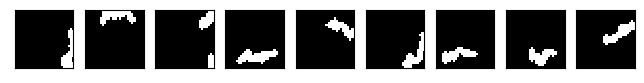

In [76]:
# Plot 9 kernels

fig, ax = plt.subplots(1,9, figsize = (8,5), dpi = 100);
for i in range(9):
    ax[i].imshow(kernels[i], cmap = 'gray')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

# MNIST Data

I'll load in the MNIST data and create a list of digits for each digit.

In [102]:
# These libraries are used to unzip and read in the binary data.
import pickle
import gzip
import json

# This is the standard numerical library for Python.
import numpy as np

def load_data():
    """ Return a tuple containing (training_data, validation_data,
    test_data). 
    
    In particular, `training_data` is a list containing 50,000
    2-tuples `(x, y)`.  
    `x` is a 784-dimensional numpy.ndarray
    containing the input image.  
    
    `y` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for `x`.
    
    `validation_data` and `test_data` are lists containing 10,000
    2-tuples `(x, y)`. In each case, `x` is a 784-dimensional
    numpy.ndarry containing the input image, and `y` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to `x`.
    
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code.
    """
    
    # Unzip and load in the binary data.
    with gzip.open('mnist.pkl.gz', 'rb') as binary_file:
        tr_d, va_d, te_d = pickle.load(binary_file, encoding="latin1")
        
    train_data = [image.reshape((28,28)) for image in tr_d[0]]
    train_labels = tr_d[1]
    
    valid_data = [image.reshape((28,28)) for image in va_d[0]]
    valid_labels = va_d[1]
    
    test_data = [image.reshape((28,28)) for image in te_d[0]]
    test_labels = te_d[1]
    
    return pd.DataFrame(zip(train_data, train_labels), columns = ['image','label']), pd.DataFrame(zip(valid_data,valid_labels), columns = ['image','label']), pd.DataFrame(zip(test_data, test_labels), columns = ['image','label'])

train, valid, test = load_data()

In [103]:
data = pd.concat([train,valid,test])
data

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",9
...,...,...
9995,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2
9996,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",3
9997,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
9998,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",5


In [104]:
# Extract only the image data from the DataFrames

def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['label'] == digit]
    
    # Now ims only contains labels matching the digit, so we can drop the label column.
    ims.drop('label', axis = 1, inplace = True)
    
    return np.array(ims['image'])

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    
    for i in range(10):
        print('{} examples of digit {}'.format(len(data[i]), i))
    print('{} examples in total\n'.format(sum(len(data[i]) for i in range(10))))
    return None

In [105]:
images = [extract_image(data, i) for i in range(10)]
display_lengths(images)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



In [111]:
# Finally, save each digit/array of digits pair as a dictionary.

digits = {key:value for key,value in zip(range(10), images)}

In [122]:
# Each key in 'digits' represents an array containing the corresponding digit.

digits.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

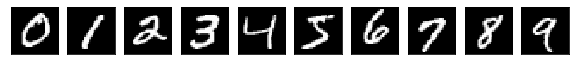

In [123]:
def display_digits(data):
    """ Display a single digit from each subset. """
    
    fig, ax = plt.subplots(1,len(data), figsize = (10,6))
    for i in range(len(data)):
        ax[i].imshow(data[i][0], cmap = 'gray')
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
    return None
        
display_digits(digits)

In [167]:
# fftconvolve(kernels[0], digits[0][0], mode = 'valid')

coords = [[fftconvolve(digits[i][0], kern, mode = 'valid') for i in range(10)] for kern in kernels]

In [180]:
coordinates = pd.DataFrame(coords, columns = ['class' + str(i) for i in range(10)])

In [181]:
for i in range(10):
    coordinates['class' + str(i)] = coordinates['class' + str(i)].apply(lambda x: float(x))

In [182]:
coordinates

,class0,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,-2.273836e-07,2.748733e-08,2.196527e-07,-8.324062e-08,-2.270760e-07,1.839221e-08,-1.394592e-07,-3.112529e-07,-4.444784e-07,2.353878e-07
1,1.335938e+00,3.460938e+00,1.222656e+00,9.921875e+00,7.542968e+00,7.894532e+00,-4.311463e-07,7.496094e+00,3.597657e+00,7.574219e+00
2,1.109375e+00,2.666634e-07,5.500000e+00,4.757812e+00,-3.002049e-07,9.570318e-01,-1.413612e-07,3.480339e-07,2.361077e-07,1.498480e-09
3,1.769141e+01,7.441406e+00,9.445312e+00,2.258984e+01,2.808594e+00,1.839844e+01,1.227344e+01,4.511719e+00,6.679688e+00,4.562500e+00
4,1.974219e+01,1.521484e+01,2.260547e+01,1.283984e+01,2.660156e+00,1.050781e+01,1.699219e+01,7.632813e+00,1.664453e+01,2.773437e-01
...,...,...,...,...,...,...,...,...,...,...
95,2.201562e+01,1.433984e+01,2.401172e+01,1.264063e+01,8.796875e+00,1.004687e+01,2.285156e+01,8.468751e+00,2.192578e+01,6.093750e+00
96,3.906270e-02,1.853729e-08,1.562504e-01,5.449219e+00,6.292969e+00,5.988281e+00,5.195307e-01,-5.584117e-08,1.757809e-01,2.770720e-07
97,2.010938e+01,1.472266e+01,1.458203e+01,2.423828e+01,-2.619652e-09,1.689844e+01,8.535156e+00,9.351563e+00,1.784375e+01,-1.374737e-07
98,2.969531e+01,1.249219e+01,1.816016e+01,3.617188e+01,9.214844e+00,3.171094e+01,1.682812e+01,1.285156e+01,2.223047e+01,1.213672e+01


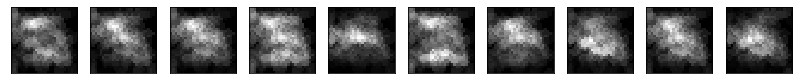

In [215]:
im = np.zeros((10,28,28))

for i in range(10):
    for k in range(len(kernels)):
        im[i,:,:] += coordinates['class' + str(i)].loc[k]*np.fliplr(kernels[k])

fig, ax = plt.subplots(1,10,figsize=(14,10))

for i in range(10):
    ax[i].imshow(im[i,:,:], cmap = 'gray')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)